# Video with detected disks

In [1]:
import sys
sys.path.append('..')

In [11]:
import os  
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from segmentation_models.backbones import get_preprocessing
from keras import backend as K
from skimage import measure

from classes.image_utils import ImageUtils
from classes.process_results import ProcessResults
from classes.model_utils import ModelUtils

## Initialize

In [5]:
val_frame_path = '/home/andrea/learning/vessel_segmentation/disk/val_imgs/val'
val_mask_path = '/home/andrea/learning/vessel_segmentation/disk/val_masks/val'
img_height = 768
img_width = 768

backbone = 'resnet18'

preprocess_input = get_preprocessing(backbone)
image_ut = ImageUtils(val_frame_path, val_mask_path, img_height, img_width, architecture='unet')
process_res = ProcessResults()

## Load model

In [7]:
model_RESNET18 = ModelUtils.load_model('/home/andrea/learning/vessel_segmentation/result_code/UNET/models/model_unet_disk_pretrainedRESNET18_6')

Loaded model from disk


## Parse and create images for video

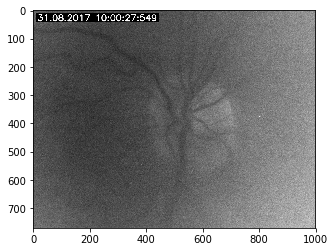

In [8]:
path_video = '/home/andrea/learning/vessel_segmentation/videa_pop2/Study_02_00056_01_L.avi'
cap = cv2.VideoCapture(path_video)
success, image = cap.read()
plt.imshow(image)

In [23]:
path_video = '/home/andrea/learning/vessel_segmentation/videa_pop2/Study_02_00056_01_L.avi'
cap = cv2.VideoCapture(path_video)
idx = 5000

while (True):
    try:
        success, image = cap.read()
        dst = cv2.fastNlMeansDenoisingColored(image, None, 6, 6, 7, 21)     

        test_img = preprocess_input(dst)
        test_img =  cv2.resize(test_img, (img_height, img_width))
        predicted_img = process_res.predict_image(test_img, model_RESNET18, backbone='resnet18')

        filt_img = process_res.med_ext_med_filter(predicted_img)
        filt_tresh_img = process_res.tresholding(filt_img)

        contours = measure.find_contours(filt_tresh_img, 0.9)
        pts = contours[0].reshape((-1,1,2))
        img = cv2.fillPoly(cv2.resize(image, (768, 768)), [np.int32(np.flip(pts, 2))], (255, 0, 255))

        opacity = 0.2
        res = cv2.addWeighted(img, opacity, (test_img).astype('uint8'), 1 - opacity, 
                              0, (test_img*255).astype('uint8'))

        idx = idx+1
        print(idx)
        cv2.imwrite("/home/andrea/learning/vessel_segmentation/result_code/UNET/disk_videa/Study_02_00056_01_L_detected/frame"+str(idx)+".jpg", res)
    except:
        cap.release()
        cv2.destroyAllWindows()
        print("Complete")
        break

5001
5002
5003
5004
Complete


In [ ]:
#!ffmpeg -pattern_type glob -i '*.jpg' -r 5 video2.mp4 